In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("figure", figsize=(12.0, 8.0))
import seaborn as sns
sns.set(color_codes=True)

In [2]:
conn = sqlite3.connect("salaries.db")
columns = ["File_Date",
           "SubAgency", 
           "Age_Range",
           "Education_Level",
           "Pay_Plan",
           "Grade",
           "LOS_Level",
           "Occupation",
           "PATCO",
           "Adjusted_Basic_Pay",
           "Supervisory_Status",
           "TOA",
           "Work_Schedule",
           "NSFTP_Indicator"]

In [3]:
num_employees = pd.read_sql_query("""
SELECT 
    File_Date AS Date, 
    Occupation,
    COUNT(*) AS Number_Employees 
FROM 
    (SELECT
        File_Date,
        REPLACE(Occupation, '1169', '0512') AS Occupation
     FROM 
         data) sub
WHERE
    File_Date LIKE '%03'
    AND Occupation IN ('0512', '1863')
GROUP BY
    File_Date,
    Occupation
;""", conn)
num_employees["Date"] = pd.to_datetime(num_employees["Date"], format="%Y%m")
num_employees["Occupation"] = num_employees["Occupation"].map({"0512": "Internal Revenue Service",
                                                               "1863": "Food Inspection"})

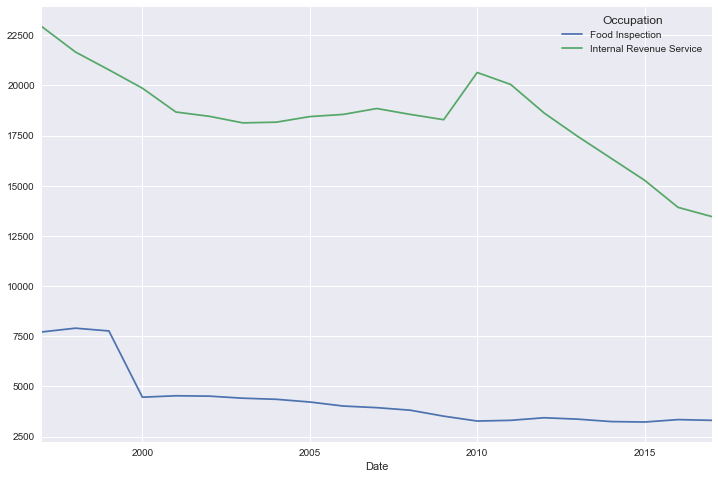

In [4]:
num_employees[num_employees["Date"] > "1997-01-01"].to_csv("num_employees.csv", index=False)
num_employees[num_employees["Date"] > "1997-01-01"]\
    .pivot(index="Date", columns="Occupation", values="Number_Employees").plot()

In [5]:
total_salaries = pd.read_sql_query("""
SELECT 
    File_Date AS Date, 
    REPLACE(Occupation, "1169", "0512") AS Occupation,
    SUM(Adjusted_Basic_Pay) AS Total_Budget 
FROM 
    (SELECT
        File_Date,
        REPLACE(Occupation, '1169', '0512') AS Occupation,
        Adjusted_Basic_Pay
     FROM 
         data) sub
WHERE
    File_Date LIKE '%03'
    AND Occupation IN ('0512', '1863')
GROUP BY
    File_Date, 
    Occupation
;""", conn)
total_salaries["Date"] = pd.to_datetime(total_salaries["Date"], format="%Y%m")
total_salaries["Occupation"] = total_salaries["Occupation"].map({"0512": "Internal Revenue Service",
                                                                 "1863": "Food Inspection"})

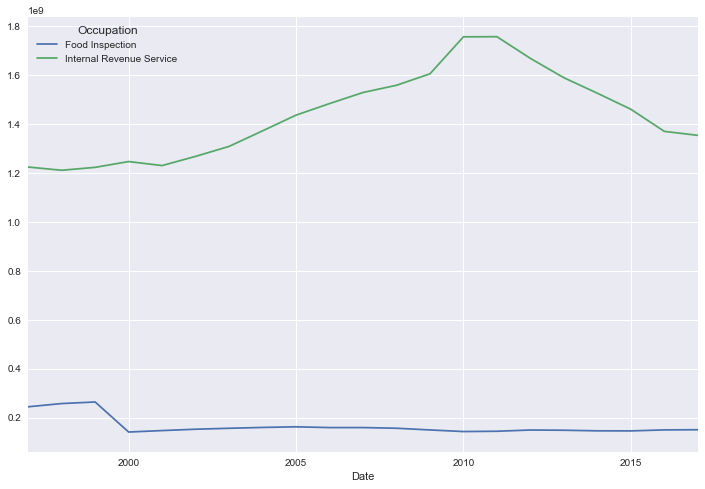

In [6]:
total_salaries[total_salaries["Date"] > "1997-01-01"].to_csv("total_salaries.csv", index=False)
total_salaries[total_salaries["Date"] > "1997-01-01"]\
    .pivot(index="Date", columns="Occupation", values="Total_Budget").plot()

In [7]:
average_salaries = pd.read_sql_query("""
SELECT 
    File_Date AS Date, 
    Occupation,
    AVG(Adjusted_Basic_Pay) AS Average_Salary
FROM 
    (SELECT
        File_Date,
        REPLACE(Occupation, '1169', '0512') AS Occupation,
        Adjusted_Basic_Pay
     FROM 
         data) sub
WHERE
    File_Date LIKE '%03'
    AND Occupation IN ('0512', '1863')
GROUP BY
    File_Date, 
    Occupation
;""", conn)
average_salaries["Date"] = pd.to_datetime(average_salaries["Date"], format="%Y%m")
average_salaries["Occupation"] = average_salaries["Occupation"].map({"0512": "Internal Revenue Service",
                                                                     "1863": "Food Inspection"})

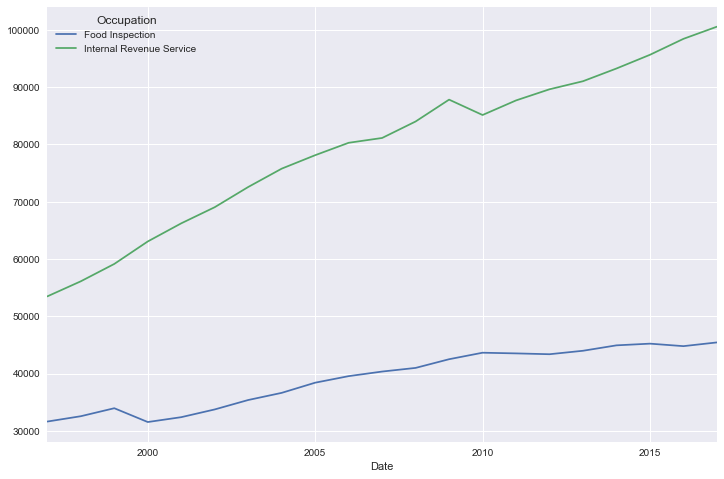

In [8]:
average_salaries[average_salaries["Date"] > "1997-01-01"].to_csv("average_salaries.csv", index=False)
average_salaries[average_salaries["Date"] > "1997-01-01"]\
.pivot(index="Date", columns="Occupation", values="Average_Salary").plot()

In [9]:
average_ages = pd.read_sql_query("""
SELECT 
    File_Date AS Date, 
    Occupation,
    Age_Range,
    COUNT(*) AS Number_Employees
FROM 
    (SELECT
        File_Date,
        REPLACE(Occupation, '1169', '0512') AS Occupation,
        Age_Range
     FROM 
         data) sub
WHERE
    File_Date LIKE '%03'
    AND Occupation IN ('0512', '1863')
GROUP BY
    File_Date, 
    Occupation,
    Age_Range
;""", conn)
average_ages["Date"] = pd.to_datetime(average_ages["Date"], format="%Y%m")
average_ages["Occupation"] = average_ages["Occupation"].map({"0512": "Internal Revenue Service",
                                                             "1863": "Food Inspection"})
average_ages["Age_Range"] = average_ages["Age_Range"].map({"15-19": 17, 
                                                           "20-24": 22,
                                                           "25-29": 27,
                                                           "30-34": 32,
                                                           "35-39": 37,
                                                           "40-44": 42,
                                                           "45-49": 47,
                                                           "50-54": 52,
                                                           "55-59": 57,
                                                           "60-64": 62,
                                                           "65+": 68})
average_ages["Total_Ages"] = average_ages["Age_Range"] * average_ages["Number_Employees"]
average_ages = pd.DataFrame(average_ages.groupby(["Date", "Occupation"])["Total_Ages"].sum() / 
                average_ages.groupby(["Date", "Occupation"])["Number_Employees"].sum())\
.rename(columns={0: "Average_Age"}).reset_index()

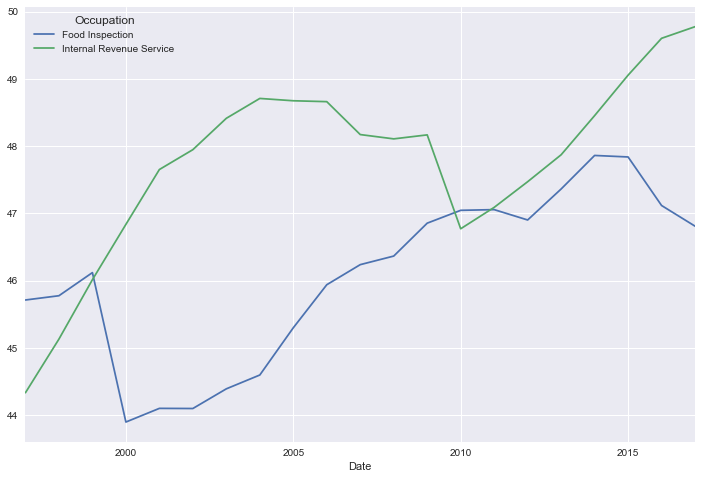

In [10]:
average_ages[average_ages["Date"] > "1997-01-01"]\
.pivot(index="Date", columns="Occupation", values="Average_Age").plot()

In [11]:
food_safety = pd.read_csv("food_safety.csv")
food_safety = food_safety[food_safety["Genus Species"]\
                          .str.contains("Norovirus|Salmonella|Campylobacter|Escherichia coli|Listeria|Clostridium", na=False)]

In [12]:
food_safety_outbreaks = food_safety\
    .groupby(["Year", "Genus Species", "Etiology Status", "Location of Preparation"])[["Illnesses"]]\
    .count()\
    .rename(columns={"Illnesses": "Outbreaks"})\
    .reset_index()\
    .groupby("Year")\
    .sum()
food_safety_illnesses = food_safety\
    .groupby(["Year", "Genus Species", "Etiology Status", "Location of Preparation"])[["Illnesses"]]\
    .sum()\
    .reset_index()\
    .groupby("Year")\
    .sum()
food_safety_hospitalizations = food_safety\
    .groupby(["Year", "Genus Species", "Etiology Status", "Location of Preparation"])[["Hospitalizations"]]\
    .sum()\
    .reset_index()\
    .groupby("Year")\
    .sum()
food_safety_deaths = food_safety\
    .groupby(["Year", "Genus Species", "Etiology Status", "Location of Preparation"])[["Deaths"]]\
    .sum()\
    .reset_index()\
    .groupby("Year")\
    .sum()

In [13]:
food_safety_metrics = pd.concat([food_safety_outbreaks, food_safety_illnesses, 
                                 food_safety_hospitalizations], axis=1)

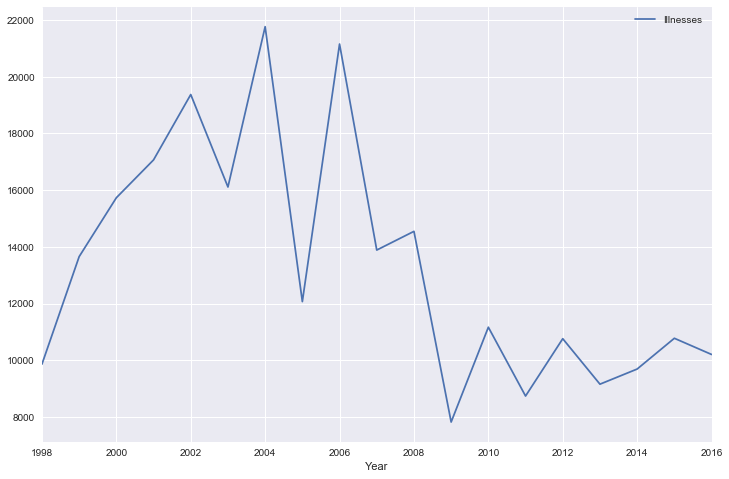

In [14]:
food_safety_illnesses.plot()

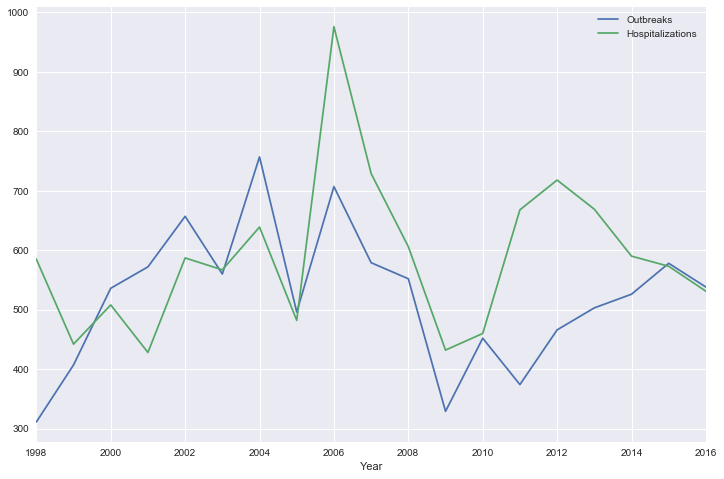

In [15]:
food_safety_metrics.to_csv("food_safety_metrics.csv")
food_safety_metrics.drop(["Illnesses"], axis=1).plot()

In [17]:
IRS = pd.read_csv("IRS_data_summary.csv", thousands=",")
IRS.set_index("Year", inplace=True)
IRS.sort_index(inplace=True)
IRS["Exam coverage"] = (IRS["Individual returns examined"] / IRS["Individual returns filed"])
IRS["Corporate exam coverage"] = (IRS["Corporate returns examined"] / IRS["Corporate returns filed"])

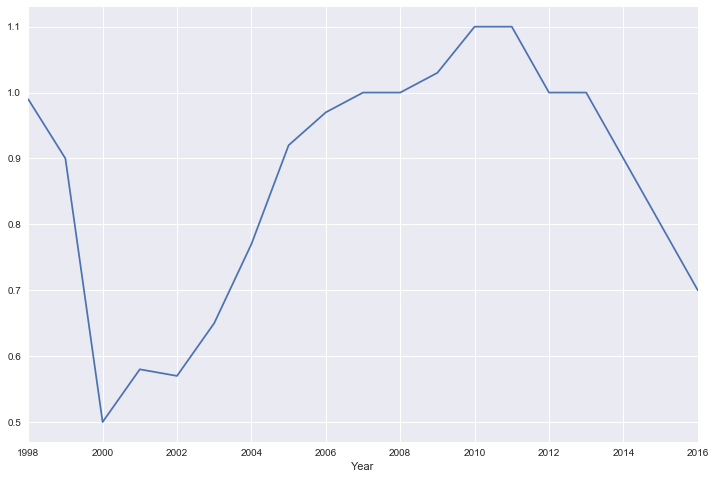

In [20]:
IRS["Individual exam coverage"].reset_index().to_csv("IRS_metric_coverage.csv", header=["Year", "Individual_Exam_Coverage"], index=False)
IRS["Individual additional tax"].reset_index().to_csv("IRS_metric_recommended.csv", 
                                                               header=["Year", "Individual_Additional_Tax"], index=False)
IRS["Individual exam coverage"].plot()

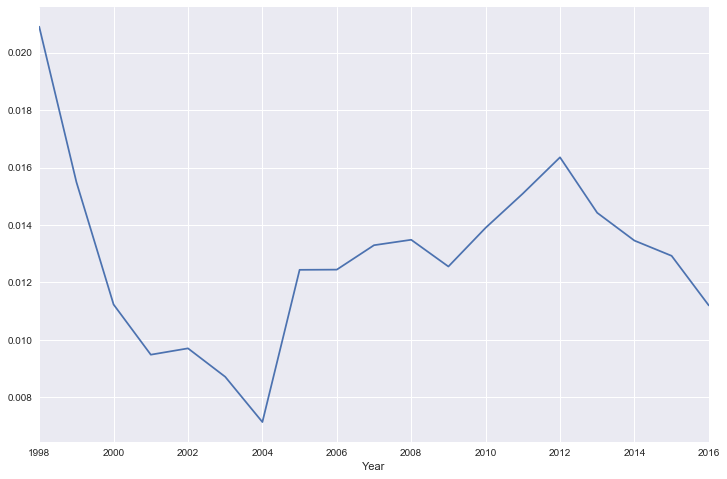

In [21]:
IRS["Corporate exam coverage"].plot()

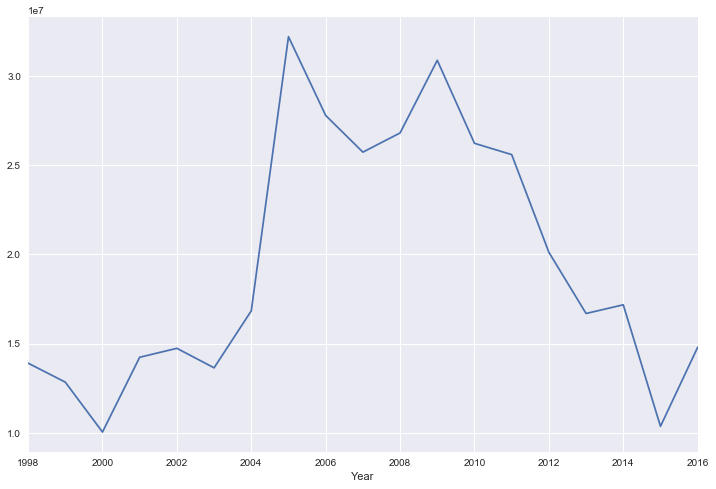

In [22]:
IRS["Corporate additional tax"].plot()

In [23]:
num_ages = pd.read_sql_query("""
SELECT 
    File_Date AS Date, 
    Occupation,
    Age_Range,
    COUNT(*) AS Number_Employees
FROM 
    (SELECT
        File_Date,
        REPLACE(Occupation, '1169', '0512') AS Occupation,
        Age_Range
     FROM 
         data) sub
WHERE
    File_Date LIKE '%03'
    AND Occupation IN ('0512', '1863')
GROUP BY
    File_Date, 
    Occupation,
    Age_Range
;""", conn)
num_ages["Date"] = pd.to_datetime(num_ages["Date"], format="%Y%m")
num_ages["Occupation"] = num_ages["Occupation"].map({"0512": "Internal Revenue Service",
                                                     "1863": "Food Inspection"})

In [24]:
IRS_num_ages = num_ages[num_ages["Occupation"] == "Internal Revenue Service"]\
    .pivot(index="Date", columns="Age_Range", values="Number_Employees").replace(np.nan, 0)
food_safety_num_ages = num_ages[num_ages["Occupation"] == "Food Inspection"]\
    .pivot(index="Date", columns="Age_Range", values="Number_Employees").replace(np.nan, 0)
IRS_num_ages["<30"] = IRS_num_ages.iloc[:, 0:3].sum(axis=1)
food_safety_num_ages["<30"] = food_safety_num_ages.iloc[:, 0:3].sum(axis=1)
IRS_num_ages["30-49"] = IRS_num_ages.iloc[:, 3:7].sum(axis=1)
food_safety_num_ages["30-49"] = food_safety_num_ages.iloc[:, 3:7].sum(axis=1)
IRS_num_ages["50+"] = IRS_num_ages.iloc[:, 7:11].sum(axis=1)
food_safety_num_ages["50+"] = food_safety_num_ages.iloc[:, 7:11].sum(axis=1)

In [25]:
num_ages = IRS_num_ages.append(food_safety_num_ages)
num_ages["Occupation"] = np.append(np.repeat("Internal Revenue Service", IRS_num_ages.shape[0]),
                                   np.repeat("Food Inspection", food_safety_num_ages.shape[0]))
num_ages = pd.DataFrame(num_ages, columns=["Occupation", "<30", "30-49", "50+"])
num_ages.reset_index(inplace=True)

In [26]:
all_data = pd.concat([average_ages.set_index(["Date", "Occupation"]), 
                           average_salaries.set_index(["Date", "Occupation"]), 
                           num_employees.set_index(["Date", "Occupation"]),
                           num_ages.set_index(["Date", "Occupation"])], axis=1)\
    .reset_index()
all_data["Year"] = all_data["Date"].apply(lambda x: x.year)
all_data.drop("Date", axis=1, inplace=True)
food_safety_metrics["Occupation"] = "Food Inspection"
IRS["Occupation"] = "Internal Revenue Service"
all_data = all_data.merge(food_safety_metrics.reset_index(), how="left", on=["Year", "Occupation"])
all_data = all_data.merge(pd.DataFrame(IRS.reset_index(), columns=["Year", "Occupation", "Exam coverage", 
                                                                   "Recommended additional tax (total)"]), 
                          how="left", on=["Year", "Occupation"])
all_data.rename(columns={"Exam coverage": "Exam_Coverage"}, inplace=True)
all_data.set_index(["Year", "Occupation"], inplace=True)
all_data.to_csv("all_data.csv")

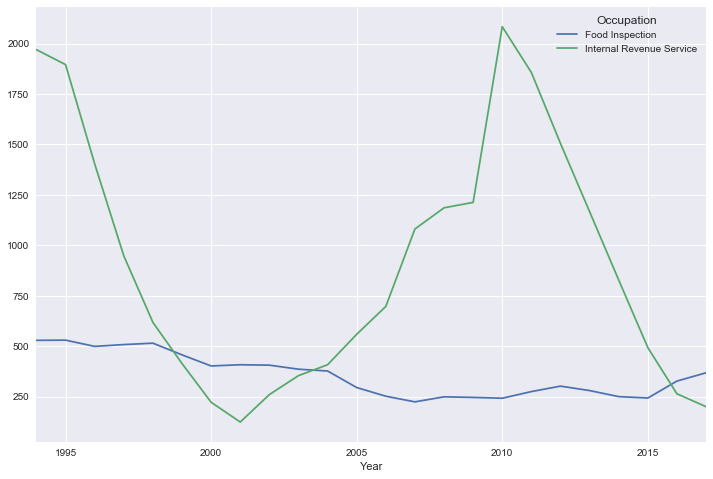

In [27]:
all_data.reset_index().iloc[40:].pivot(index="Year", columns="Occupation", values="<30").plot()

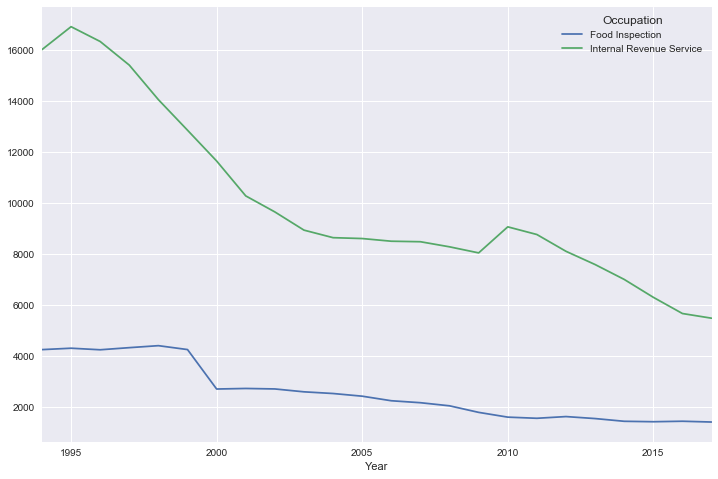

In [28]:
all_data.reset_index().iloc[40:].pivot(index="Year", columns="Occupation", values="30-49").plot()

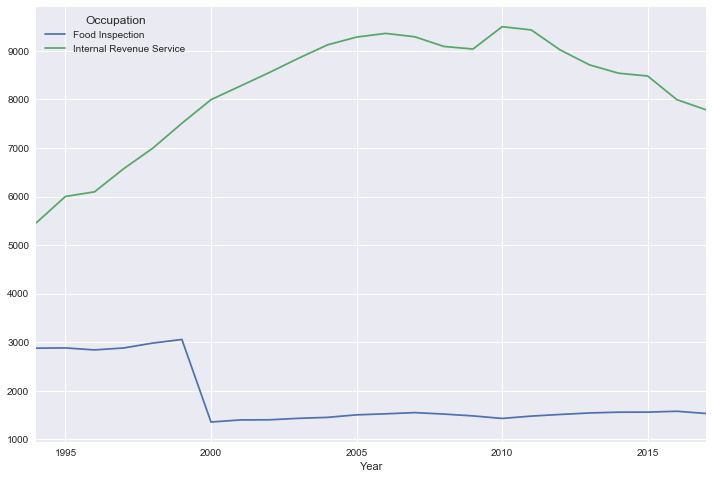

In [29]:
all_data.reset_index().iloc[40:].pivot(index="Year", columns="Occupation", values="50+").plot()

In [50]:
# conn.close()